# Utrecht Housing Problem
Solves the problem using the custom linear unit
implementation and a library for comparison and validation (multiple inputs, single output).

Kaggle link: https://www.kaggle.com/datasets/ictinstitute/utrecht-housing-dataset

In [1]:
import copy
import os
import warnings

import dotenv
_ = dotenv.load_dotenv()
warnings.filterwarnings('ignore')

import kagglehub
import keras
import pandas as pd
import statsmodels.api as sm
from matplotlib import gridspec as gridspec
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection._split import train_test_split
from sklearn.preprocessing import StandardScaler

from app.loggers import get_logger
from app.models import LinearUnit

logger = get_logger(__name__)

In [2]:
def get_data_report(x, y):
    x = copy.deepcopy(x)
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    logger.info(model.summary())
    residuals = model.resid

    plt.scatter(model.fittedvalues, residuals)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.show()

## Data

In [3]:
data_dir_fp = kagglehub.dataset_download("ictinstitute/utrecht-housing-dataset")
os.listdir(data_dir_fp)

['utrechthousingsmall.csv',
 'utrechthousinglarge.csv',
 '2025-housing-dataset-alldata.csv',
 'utrechthousinghuge.csv']

In [4]:
data_fp = os.path.join(data_dir_fp, "utrechthousinghuge.csv")
df = pd.read_csv(data_fp)
df.columns = df.columns.str.strip()
df

,id,zipcode,lot-len,lot-width,lot-area,house-area,garden-size,balcony,x-coor,y-coor,buildyear,bathrooms,taxvalue,retailvalue,energy-eff,monument
0,100426,3528,11.1,5.0,55.5,112.50,10.5,2,2112,5113,1932,1,494000,670000,0,1
1,100871,3528,13.6,5.0,68.0,112.50,8.0,0,2355,5218,1945,1,504000,675000,0,1
2,100936,3800,16.6,6.7,111.2,150.75,44.2,2,2656,5200,1946,1,692000,869000,0,1
3,100970,3800,18.6,6.0,111.6,108.00,39.6,2,2856,5201,1946,1,521000,628000,0,1
4,101191,3800,19.6,6.0,117.6,108.00,45.6,1,2962,5266,1950,1,526000,610000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,993057,3525,12.5,7.9,98.8,142.20,19.8,2,2252,5752,1990,2,648000,765000,1,0
1996,993131,3500,16.5,7.5,123.8,135.00,33.8,2,2650,5768,1992,1,639000,728000,0,0
1997,993444,3525,12.0,6.5,78.0,146.25,19.5,2,2204,5854,2000,2,647000,733000,1,0
1998,993873,3525,13.5,7.6,102.6,136.80,26.6,1,2352,5958,2015,2,629000,694000,1,0


## Analysis

2025-12-25 21:17:14,230 - deep_learning.__main__ - INFO -                             OLS Regression Results                            
Dep. Variable:            retailvalue   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 1.501e+04
Date:                Thu, 25 Dec 2025   Prob (F-statistic):               0.00
Time:                        21:17:14   Log-Likelihood:                -22685.
No. Observations:                2000   AIC:                         4.540e+04
Df Residuals:                    1985   BIC:                         4.548e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

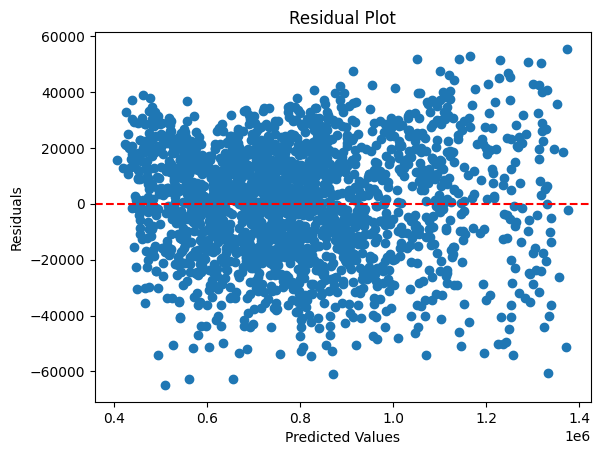

2025-12-25 21:17:14,409 - deep_learning.__main__ - INFO -                             OLS Regression Results                            
Dep. Variable:            retailvalue   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 1.501e+04
Date:                Thu, 25 Dec 2025   Prob (F-statistic):               0.00
Time:                        21:17:14   Log-Likelihood:                -22685.
No. Observations:                2000   AIC:                         4.540e+04
Df Residuals:                    1985   BIC:                         4.548e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

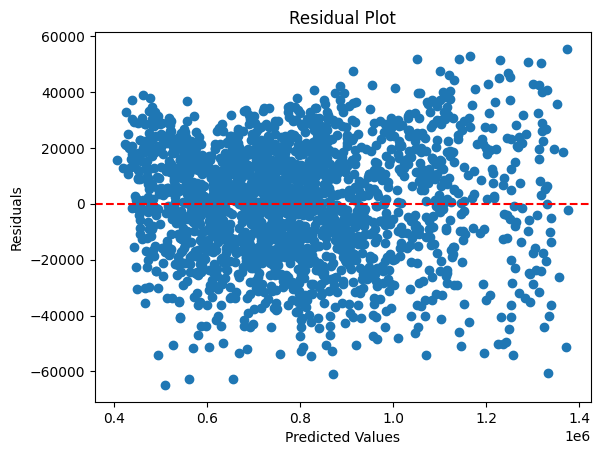

In [5]:
df_numeric = df
df_numeric = df.select_dtypes(include=['number'])
X = pd.get_dummies(df_numeric, columns=['zipcode'], drop_first=True).astype(float)
df_numeric = df_numeric.fillna(df_numeric.mean())

df_clean = df_numeric.dropna()

target_cols = ['retailvalue', 'taxvalue']
X = df_clean.drop(columns=target_cols)
for tc in target_cols:
    y = df_clean[target_cols[0]]
    get_data_report(X, y)
y = df_clean[target_cols]

## Data Preparation

In [6]:
X = X.drop(columns=['id', 'buildyear', 'lot-len', 'lot-width'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

## Parameters

In [7]:
learning_rate = 0.001
batch_size = 32
epochs = 160

## Training

In [8]:
# Scikit Linear Regression
sk_model = LinearRegression()
logger.info("Training Linear Regression")
sk_model.fit(X_train_scaled, y_train_scaled)
sk_model_preds = scaler_y.inverse_transform(sk_model.predict(X_test_scaled))
sk_score = r2_score(y_test, sk_model_preds)

my_init = keras.initializers.RandomNormal(mean=0.0, stddev=1.0)

# Keras
model_keras = keras.Sequential(
    [
        keras.layers.Dense(
            2,
            input_shape=(X_train_scaled.shape[1:]),
            activation="linear",
            kernel_initializer=my_init,
            bias_initializer=my_init,
            dtype='float64',
        )
    ]
)
model_keras.compile(
    optimizer=keras.optimizers.SGD(learning_rate=learning_rate), loss="mse"
)
logger.info("Training Keras Model")
model_keras.fit(X_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, shuffle=True)
keras_preds = scaler_y.inverse_transform(model_keras.predict(X_test_scaled))
keras_score = r2_score(y_test, keras_preds)

# Linear Unit
linear_unit = LinearUnit(X_train_scaled.tolist(), y_train_scaled.tolist())
logger.info("Training Linear Unit")
linear_unit.train(learning_rate=learning_rate, epochs=epochs, batch_size=batch_size)
lu_preds = scaler_y.inverse_transform(linear_unit.infer(X_test_scaled.tolist()).to_list())
lu_score = r2_score(y_test, lu_preds)

2025-12-25 21:17:14,559 - deep_learning.__main__ - INFO - Training Linear Regression (4057868000.py:3)
E0000 00:00:1766715434.594756   10358 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1766715434.606823   10358 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-12-25 21:17:14,692 - deep_learning.__main__ - INFO - Training Keras Model (4057868000.py:26)


Epoch 1/160
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.4912
Epoch 2/160
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0391
Epoch 3/160
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8878
Epoch 4/160
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9678
Epoch 5/160
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2280
Epoch 6/160
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6297
Epoch 7/160
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1420
Epoch 8/160
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7418
Epoch 9/160
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4113
Epoch 10/160
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1368
Epoch 11/160
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9071
Epoch 12/160
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7139
Epoch 13/160
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5505
Epoch 14/160
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4115
Epoch 15/160
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2928
Epoc

2025-12-25 21:17:35,060 - deep_learning.__main__ - INFO - Training Linear Unit (4057868000.py:33)


## Results

In [9]:
logger.info("Total rows: %s", len(X))
logger.info("LinearReg W: %s", sk_model.coef_)
logger.info("LinearReg b: %s", sk_model.intercept_)
logger.info("Linear Unit W: %s", linear_unit.w_current.matrix)
logger.info("Linear Unit b: %s", linear_unit.b_current.matrix)
logger.info("Linear Unit latest loss: %s", linear_unit.epoch_loss_scores[-1])
logger.info(
    "\nScores:\n====================\nLinearReg Score:%s\nKeras Score:%s\nLinear Unit Score:%s",
    sk_score,
    keras_score,
    lu_score,
)

2025-12-25 21:17:36,731 - deep_learning.__main__ - INFO - Total rows: 2000 (1395121864.py:1)
2025-12-25 21:17:36,732 - deep_learning.__main__ - INFO - LinearReg W: [[-1.26599308e-02  2.89076923e-01  8.85810486e-01 -5.98012165e-02
   3.00902422e-02 -1.74775347e-01 -2.27257221e-01  1.27504543e-02
  -1.47221358e-02  9.89735992e-03]
 [ 1.13391717e-05  1.49975598e-01  9.14344781e-01 -1.05331634e-04
  -2.52506443e-05 -8.68985922e-06 -6.84461868e-05  1.16317331e-04
  -1.50174430e-04 -6.31203608e-05]] (1395121864.py:2)
2025-12-25 21:17:36,733 - deep_learning.__main__ - INFO - LinearReg b: [3.44543972e-16 2.49326847e-16] (1395121864.py:3)
2025-12-25 21:17:36,733 - deep_learning.__main__ - INFO - Linear Unit W: [[-0.022929898016552142, -0.018742702929969456], [0.268743193484529, 0.30641973016034724], [0.9870778439191357, 0.8493834348059555], [-0.4374043251666578, 0.013532438022608081], [0.0033447203699085775, 0.007033575864902264], [0.22817432750613792, -0.12214703565773824], [-0.200204928321347

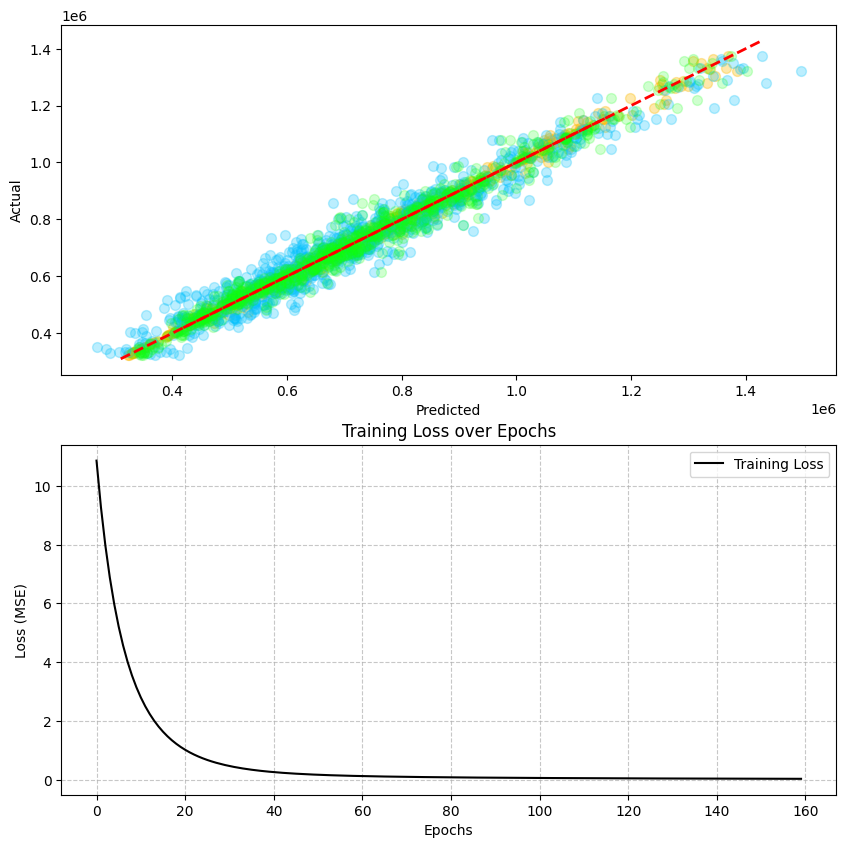

In [10]:
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)
data_pt = fig.add_subplot(gs[0, :])
data_pt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2) 
data_pt.set_xlabel('Predicted')
data_pt.set_ylabel('Actual')
data_pt.scatter(sk_model_preds, y_test, color="#fcba0355", s=50) #orange
data_pt.scatter(keras_preds, y_test, color="#03c2fc44", s=50) # blue
data_pt.scatter(lu_preds, y_test, color="#11ff1133", s=50) #green

loss_pt = fig.add_subplot(gs[1, :])
loss_pt.plot(linear_unit.epoch_loss_scores, label="Training Loss", color="black")
loss_pt.set_title("Training Loss over Epochs")
loss_pt.set_xlabel("Epochs")
loss_pt.set_ylabel("Loss (MSE)")
loss_pt.grid(True, linestyle="--", alpha=0.7)
loss_pt.legend()
plt.show()